In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# from fastai import *

from fastai.text import *

In [3]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/storage/imdb_sample/models'),
 PosixPath('/storage/imdb_sample/data_lm.pkl'),
 PosixPath('/storage/imdb_sample/texts.csv')]

In [4]:
path

PosixPath('/storage/imdb_sample')

# need not to run these cells

data_lm = (TextList.from_csv(path,'texts.csv')
           #Inputs: all the text files in path
            .filter
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=24))

In [10]:
data_lm=TextLMDataBunch.from_csv(path,'texts.csv')

In [11]:
data_lm.show_batch()

idx,text
0,". xxmaj it was an interesting character study and very well shot ( on digital video , unusual for a period piece ) . xxmaj the acting was excellent all round , particularly xxmaj tim xxunk and xxmaj brian xxmaj cox although the actor who portrayed xxup acd , whose name i can not remember impressed me no end . xxmaj an excellent character study which has about the same"
1,"tied in to the xxmaj valentine 's xxmaj day theme . \n \n xxmaj many viewers will likely xxunk points from the film for its various cliché - rooted but implausible scenarios and plot developments . xxmaj however , in light of the above , the film is intentionally clichéd , implausible and ludicrous . xxmaj it 's as if xxmaj blanks is attempting ( and mostly xxunk )"
2,"best to come out of the 1980s . xxmaj it has the best soundtrack of xxup any movie of the last 50 years at least , highly quotable lines , and the xxunk scene is xxup hilarious ! ! xxmaj plus xxmaj apollonia is just simply xxup stunning . xxmaj on an unrelated not , when i saw xxmaj prince in concert in 2004 he blew down the stadium ."
3,"it , but i will not waste my time and there is no place for it in my studies of xxmaj shakespeare . xxmaj after twenty five minutes i gave up and that was the end . i then read all the comments on this website and the xxunk of the film is only matched by its xxunk . ' xxmaj its a painting xxrep 5 . then put it"
4,"on xxmaj american 's contemporary thematics : "" xxmaj the xxmaj bourne xxmaj ultimatum "" is definitely the best movie of the series and a very interesting and original action flick . xxbos xxmaj this movie was the most out of line and xxunk fed movie i have ever seen in my life . ( xxmaj besides xxmaj xxunk 9 / 11 ) . xxmaj all of the information was"


In [12]:
data_lm.save('data_lm.pkl')

In [13]:
path.ls()

[PosixPath('/storage/imdb_sample/data_lm.pkl'),
 PosixPath('/storage/imdb_sample/texts.csv')]

# data_lm load & language model

In [5]:
data_lm=load_data(path,'data_lm.pkl',bs=24)

In [15]:
learn_lm=language_model_learner(data_lm,AWD_LSTM,metrics=accuracy)

In [18]:
learn_lm.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.98E-03


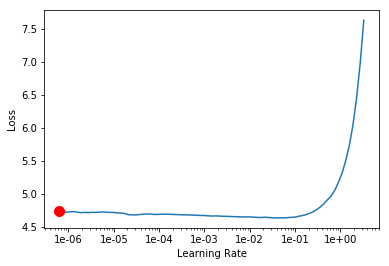

In [19]:
learn_lm.recorder.plot(suggestion=True)

In [21]:
learn_lm.fit_one_cycle(1,1e-2,moms=(.8,.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.232323,3.859287,0.290320,00:11


In [24]:
learn_lm.save('stage-1-lm')

In [41]:
learn_lm=learn_lm.load('stage-1-lm')

In [42]:
learn_lm.unfreeze()

In [43]:
learn_lm.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 4.37E-04


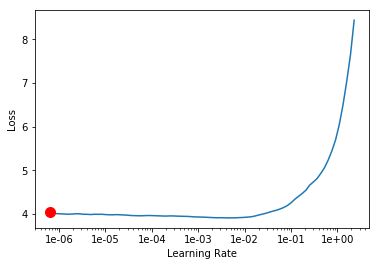

In [44]:
learn_lm.recorder.plot(suggestion=True)

In [45]:
learn_lm.fit_one_cycle(10,1e-6,moms=(.8,.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.970282,3.858656,0.290570,00:14
1,3.927373,3.858125,0.290586,00:14
2,3.953663,3.855994,0.291338,00:14
3,3.947718,3.854969,0.291494,00:15
4,3.920643,3.852854,0.291165,00:15
5,3.940578,3.853959,0.291150,00:15
6,3.947492,3.851573,0.291463,00:15
7,3.941434,3.851390,0.292215,00:14
8,3.938831,3.851371,0.291541,00:14
9,3.955028,3.852766,0.291369,00:15


In [46]:
learn_lm.fit_one_cycle(5,1e-4,moms=(.8,.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.931238,3.836665,0.293484,00:14
1,3.882957,3.820668,0.294721,00:14
2,3.819980,3.809274,0.296303,00:14
3,3.788870,3.805551,0.296977,00:14
4,3.776370,3.805614,0.297259,00:14


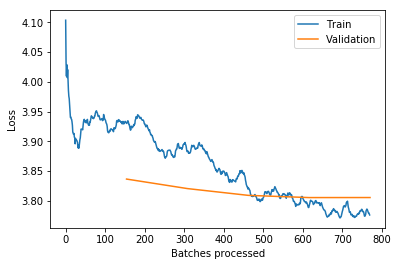

In [47]:
learn_lm.recorder.plot_losses()

In [48]:
learn_lm.fit_one_cycle(5,1e-3,moms=(.8,.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.771367,3.821330,0.293954,00:14
1,3.753924,3.838389,0.290022,00:14
2,3.540854,3.819952,0.293578,00:14
3,3.345196,3.828476,0.293311,00:15
4,3.189799,3.839098,0.293108,00:14


In [49]:
learn_lm.fit_one_cycle(5,1e-3,moms=(.8,.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.206358,3.861010,0.289771,00:14
1,3.237031,3.867105,0.289411,00:14
2,3.091049,3.914563,0.285276,00:14
3,2.876785,3.936654,0.285150,00:14
4,2.733877,3.965166,0.283631,00:14


In [50]:
learn_lm.save('fine_tuned-lm')

In [52]:
learn_lm=learn_lm.load('fine_tuned-lm')

In [56]:
learn_lm.predict('OH MY GOD', 40,temperature=0.5)

'OH MY GOD ! i was in the Hollywood Movies when i was in the Navy . i was a Naval veteran of the Vietnam war , and i had watched it in France . Now'

In [57]:
learn_lm.save_encoder('fine_tuned_lm_enc')

#  classifier 

In [7]:
data_clas=(TextList.from_csv(path,'texts.csv',vocab=data_lm.vocab,cols='text')
          .split_from_df(col=2)
          .label_from_df(cols=0)
          .databunch(bs=24))

In [13]:
data_clas.save('data_cals')

In [14]:
data_clas.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , steaming bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the xxunk - up xxunk of xxmaj new xxmaj xxunk . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj xxunk",positive
"xxbos xxmaj many xxunk that this is n't just a classic due to the fact that it 's the first xxup xxunk game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . xxmaj with graphics",positive


### this didn't go well

In [10]:
learn_clas=text_classifier_learner(data_clas,AWD_LSTM,metrics=accuracy)


learn_clas.load_encoder('fine_tuned_lm_enc');

In [15]:
learn_clas.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-03
Min loss divided by 10: 1.00E-02


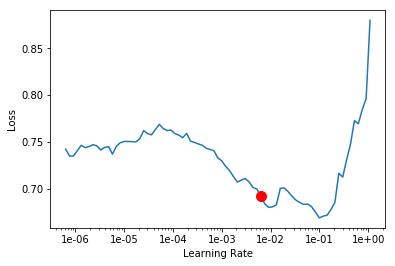

In [16]:
learn_clas.recorder.plot(suggestion=True)

In [17]:
learn_clas.fit_one_cycle(2,6.31E-03)

epoch,train_loss,valid_loss,accuracy,time
0,0.627753,0.560119,0.755000,00:08
1,0.553909,0.492390,0.770000,00:08


In [18]:
learn_clas.fit_one_cycle(2*4,6.31E-03)

epoch,train_loss,valid_loss,accuracy,time
0,0.494970,0.494516,0.765000,00:07
1,0.491057,0.465313,0.805000,00:07
2,0.484555,0.489309,0.760000,00:08
3,0.496772,0.482389,0.765000,00:08
4,0.490312,0.416778,0.835000,00:08
5,0.470223,0.415061,0.825000,00:08
6,0.450634,0.416214,0.830000,00:07
7,0.446545,0.413865,0.820000,00:07


In [19]:
doc(text_classifier_learner)

### lets try again

In [21]:
learn_clas=text_classifier_learner(data_clas,AWD_LSTM,drop_mult=0.5)


learn_clas.load_encoder('fine_tuned_lm_enc');

In [22]:
learn_clas.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.20E-03
Min loss divided by 10: 1.00E-02


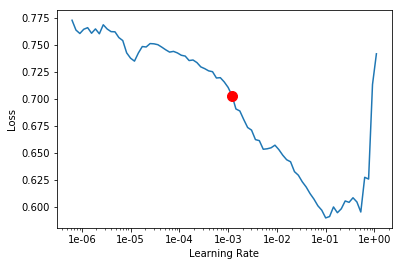

In [24]:
learn_clas.recorder.plot(suggestion=True)

In [25]:
learn_clas.fit_one_cycle(4,1.20E-03)

epoch,train_loss,valid_loss,accuracy,time
0,0.608103,0.555411,0.730000,00:08
1,0.508444,0.458989,0.775000,00:08
2,0.414975,0.454238,0.795000,00:08
3,0.360972,0.455379,0.780000,00:08


In [26]:
learn_clas.fit_one_cycle(4,1.20E-04)

epoch,train_loss,valid_loss,accuracy,time
0,0.314828,0.451063,0.800000,00:08
1,0.309935,0.456634,0.805000,00:08
2,0.310963,0.453427,0.800000,00:08
3,0.296739,0.451727,0.810000,00:08


In [27]:
# moms=(0.8,0.7)
learn_clas.fit_one_cycle(4,1.20E-03,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.298909,0.495417,0.790000,00:07
1,0.306626,0.504188,0.780000,00:08
2,0.279821,0.468631,0.805000,00:07
3,0.265457,0.467453,0.800000,00:08


In [28]:
learn_clas.save('first')

In [30]:
learn_clas.load('first');

In [31]:
learn_clas.freeze_to(-2);
learn_clas.fit_one_cycle(4,slice(1.20E-03/(2.6**4),1.2e-3),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.268598,0.499192,0.760000,00:09
1,0.250228,0.475654,0.805000,00:08
2,0.225358,0.484311,0.805000,00:09
3,0.188979,0.468929,0.805000,00:08


In [ ]:
learn_clas.save('second')

learn_clas.load('second');

In [40]:
learn_clas.freeze_to(-3);
learn_clas.fit_one_cycle(1,slice(8e-04/(2.6**4),8e-4),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.171267,0.467850,0.815000,00:12


In [41]:
learn_clas.save('third')
learn_clas.load('third');

In [42]:
learn_clas.unfreeze();
learn_clas.fit_one_cycle(4,slice(1.20E-03/(2.6**4),1.2e-3),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.157926,0.504018,0.790000,00:15
1,0.159434,0.544490,0.815000,00:16
2,0.137761,0.530067,0.810000,00:16
3,0.109640,0.510498,0.810000,00:14


In [47]:
learn_clas.predict_with_mc_dropout('bad')

[(Category positive, tensor(1), tensor([0.4055, 0.5945])),
 (Category positive, tensor(1), tensor([0.0023, 0.9977])),
 (Category positive, tensor(1), tensor([0.0511, 0.9489])),
 (Category negative, tensor(0), tensor([0.9638, 0.0362])),
 (Category negative, tensor(0), tensor([0.5627, 0.4373])),
 (Category negative, tensor(0), tensor([0.5329, 0.4671])),
 (Category negative, tensor(0), tensor([0.9083, 0.0917])),
 (Category positive, tensor(1), tensor([0.2208, 0.7792])),
 (Category negative, tensor(0), tensor([0.5230, 0.4770])),
 (Category positive, tensor(1), tensor([0.3949, 0.6051]))]